In [278]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from string import ascii_lowercase

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv
/kaggle/input/enzyme-train-with-groups/train_with_groups.csv


**Downloading datasets**

In [279]:
train = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/train.csv')
train_upd = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv')
test = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/test.csv')
submission = pd.read_csv('/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv')


# Used GroupKfold based on the groups generated here : https://www.kaggle.com/code/cdeotte/train-data-contains-mutations-like-test-data/data?scriptVersionId=106523489&select=train_with_groups.csv
# path = '../input/enzyme-train-with-groups/train_with_groups.csv'
# train_df = pd.read_csv(path)

**Replacing wrong data**

In [280]:
drop_seq_ids = train_upd[train_upd.isnull().sum(axis=1)==4]['seq_id']
train = train[~train.seq_id.isin(drop_seq_ids)]
replace_seq_ids = train_upd.loc[train_upd.isnull().sum(axis=1)!=4,"seq_id"]
train = train[~train.seq_id.isin(replace_seq_ids)]
correct_df = train_upd[train_upd.isnull().sum(axis=1)!=4]
train = pd.concat([train, correct_df], ignore_index=True)

In [281]:
train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
28976,1122,DVSGTVCLSALPPEAVDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28977,1125,DVSGVVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28978,13447,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,NaN,64.9
28979,13449,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,NaN,64.9


In [282]:
train.dropna(inplace=True)

train['tm1'] = train.tm

**Most frequent char combinations as features**

In [283]:
# Top 2 chars features (most frequent)
cols2 = ['aa',
 'ae',
 'ag',
 'ai',
 'ak',
 'al',
 'as',
 'av',
 'da',
 'de',
 'dl',
 'ea',
 'ed',
 'ee',
 'eg',
 'ek',
 'el',
 'er',
 'es',
 'ev',
 'ga',
 'ge',
 'gg',
 'gk',
 'gl',
 'gs',
 'gv',
 'ia',
 'il',
 'ka',
 'ke',
 'kk',
 'kl',
 'ks',
 'la',
 'ld',
 'le',
 'lg',
 'li',
 'lk',
 'll',
 'ln',
 'lp',
 'lq',
 'lr',
 'ls',
 'lt',
 'lv',
 'pe',
 'pl',
 'ps',
 'ql',
 'rl',
 'sa',
 'se',
 'sg',
 'sk',
 'sl',
 'sp',
 'ss',
 'st',
 'sv',
 'ta',
 'tl',
 'ts',
 'va',
 've',
 'vl',
 'vs',
 'vv']
# Top 3 chars features (most frequent)
cols3 = ['aaa',
 'aae',
 'aag',
 'aal',
 'aas',
 'aav',
 'aea',
 'aee',
 'ael',
 'agl',
 'ala',
 'ale',
 'alg',
 'alk',
 'all',
 'alr',
 'als',
 'asl',
 'ass',
 'ava',
 'avl',
 'dee',
 'dll',
 'eaa',
 'eae',
 'eal',
 'eea',
 'eee',
 'eek',
 'eel',
 'ekl',
 'ela',
 'ele',
 'elk',
 'ell',
 'erl',
 'esl',
 'evl',
 'ggg',
 'ggs',
 'gla',
 'gll',
 'gsg',
 'gss',
 'kal',
 'kel',
 'kkl',
 'kll',
 'laa',
 'lae',
 'lag',
 'lak',
 'lal',
 'las',
 'ldl',
 'lea',
 'lee',
 'lek',
 'lel',
 'lgl',
 'lka',
 'lke',
 'lkk',
 'lla',
 'lld',
 'lle',
 'llg',
 'llk',
 'lll',
 'llq',
 'llr',
 'lls',
 'llt',
 'llv',
 'lre',
 'lrl',
 'lsa',
 'lse',
 'lsg',
 'lsl',
 'lss',
 'lvl',
 'qll',
 'rll',
 'saa',
 'sal',
 'sas',
 'sgs',
 'sla',
 'sll',
 'sls',
 'ssa',
 'ssg',
 'ssl',
 'sss',
 'tll',
 'vaa',
 'vla',
 'vll']
# Top 4 chars features (most frequent)
cols4 = ['aaaa',
 'aaal',
 'aaas',
 'aaav',
 'aaga',
 'aala',
 'aalg',
 'aall',
 'aavr',
 'aeal',
 'alaa',
 'alal',
 'alea',
 'alga',
 'alke',
 'alla',
 'alle',
 'alll',
 'asss',
 'avaa',
 'deee',
 'eaaa',
 'eaal',
 'eaav',
 'eaek',
 'eala',
 'eale',
 'ealk',
 'eall',
 'ealr',
 'eeal',
 'eeea',
 'eeed',
 'eeee',
 'eeek',
 'eeel',
 'eele',
 'eelk',
 'eell',
 'elae',
 'elar',
 'elee',
 'ella',
 'elle',
 'ellk',
 'erlr',
 'gggg',
 'gggs',
 'gsss',
 'klle',
 'laaa',
 'laal',
 'laek',
 'lael',
 'laks',
 'lala',
 'lall',
 'leaa',
 'leal',
 'leea',
 'leee',
 'leel',
 'lekl',
 'lell',
 'lkal',
 'lkel',
 'lkkl',
 'llaa',
 'llae',
 'llal',
 'llea',
 'llee',
 'llek',
 'llel',
 'llke',
 'llla',
 'llle',
 'llll',
 'lllv',
 'llsa',
 'llsl',
 'lltk',
 'lrlk',
 'lsal',
 'lsll',
 'lssl',
 'lsss',
 'lvll',
 'rlll',
 'saaa',
 'sall',
 'sass',
 'sgse',
 'sgss',
 'slss',
 'ssas',
 'ssgs',
 'ssls',
 'sssa',
 'sssg',
 'sssl',
 'ssss',
 'ssst',
 'vaaa',
 'vlls']
# Top 5 chars features (most frequent)
cols5 = ['aaaaa',
 'aaaag',
 'aaaal',
 'aaaas',
 'aaaat',
 'aaaav',
 'aaala',
 'aaava',
 'aalaa',
 'aalgf',
 'aavrg',
 'aleal',
 'algal',
 'allea',
 'assss',
 'avaaa',
 'deeed',
 'deeee',
 'eaaaa',
 'eaavn',
 'eaekl',
 'ealke',
 'eeale',
 'eeedd',
 'eeede',
 'eeeed',
 'eeeee',
 'eeeek',
 'eelkk',
 'elaek',
 'elart',
 'erlrl',
 'ggggg',
 'ggggs',
 'gggsg',
 'gssss',
 'laekl',
 'laksi',
 'lealk',
 'lllvd',
 'llsag',
 'llsll',
 'lltks',
 'lrlki',
 'lsssa',
 'lssss',
 'lsssy',
 'lvlll',
 'lvlls',
 'rlllv',
 'saaaa',
 'sallq',
 'sasss',
 'sgsea',
 'sgsed',
 'sgsss',
 'slsss',
 'ssass',
 'ssgss',
 'sslss',
 'sssan',
 'sssas',
 'sssgg',
 'sssgs',
 'ssssa',
 'ssssd',
 'ssssg',
 'ssssl',
 'sssss',
 'sssst',
 'sssts',
 'vaaaa',
 'vllsl',
 'vllsv']


In [284]:
def uniq_chars(seq):
    s = set(seq)
    return len(s)

In [285]:
train = train.drop('data_source', axis=1)
train['len_seq'] = train.protein_sequence.apply(lambda x: len(x))
train['unique_chars'] = train.protein_sequence.apply(lambda x: uniq_chars(x))

for char in ascii_lowercase:
    train[char] = train.protein_sequence.apply(lambda x: x.lower().count(char))
    
train['seq1'] = train['protein_sequence'].apply(lambda x: x[:len(x)//5])
train['seq2'] = train['protein_sequence'].apply(lambda x: x[len(x)//5:2*len(x)//5])
train['seq3'] = train['protein_sequence'].apply(lambda x: x[2*len(x)//5:3*len(x)//5])
train['seq4'] = train['protein_sequence'].apply(lambda x: x[3*len(x)//5:4*len(x)//5])
train['seq5'] = train['protein_sequence'].apply(lambda x: x[4*len(x)//5:])

for char in ascii_lowercase:
    train[char+'1'] = train.seq1.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    train[char+'2'] = train.seq2.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    train[char+'3'] = train.seq3.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    train[char+'4'] = train.seq4.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    train[char+'5'] = train.seq5.apply(lambda x: x.lower().count(char))
    
for char1 in ascii_lowercase:
    for char2 in ascii_lowercase:
        train[char1+char2] = train.protein_sequence.apply(lambda x: x.lower().count(char1+char2))
    
# for char1 in ascii_lowercase:
#     for char2 in ascii_lowercase:
#         for char3 in ascii_lowercase:
#             train[char1+char2+char3] = train.protein_sequence.apply(lambda x: x.lower().count(char1+char2+char3))

# for col in cols4:
#     for char2 in ascii_lowercase:
#         train[col+char2] = train.protein_sequence.apply(lambda x: x.lower().count(col+char2))

# for col in cols2:
#     train[col] = train.protein_sequence.apply(lambda x: x.lower().count(col)) 

train = train.drop(['protein_sequence', 'seq_id'], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

In [286]:
charfull = [x for x in ascii_lowercase]
char1full = [x + '1' for x in ascii_lowercase]
char2full = [x + '2' for x in ascii_lowercase]
char3full = [x + '3' for x in ascii_lowercase]
char4full = [x + '4' for x in ascii_lowercase]
char5full = [x + '5' for x in ascii_lowercase]

In [287]:
train

,pH,tm,tm1,len_seq,unique_chars,a,b,c,d,e,...,zq,zr,zs,zt,zu,zv,zw,zx,zy,zz
0,7.0,1,75.7,341,20,45,0,1,13,30,...,0,0,0,0,0,0,0,0,0,0
1,7.0,1,50.5,286,19,28,0,0,10,52,...,0,0,0,0,0,0,0,0,0,0
2,7.0,0,40.5,497,20,50,0,9,27,32,...,0,0,0,0,0,0,0,0,0,0
3,7.0,0,47.2,265,20,20,0,5,19,29,...,0,0,0,0,0,0,0,0,0,0
4,7.0,1,49.5,1451,20,86,0,14,78,78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28951,7.0,1,51.8,549,20,33,0,12,38,31,...,0,0,0,0,0,0,0,0,0,0
28952,7.0,1,37.2,469,20,37,0,5,21,29,...,0,0,0,0,0,0,0,0,0,0
28953,7.0,0,64.6,128,20,13,0,1,7,7,...,0,0,0,0,0,0,0,0,0,0
28954,7.0,1,50.7,593,20,47,0,5,34,36,...,0,0,0,0,0,0,0,0,0,0


In [288]:
# target = train['tm1']
# train = train.drop(['tm1', 'tm'], axis=1)

In [289]:
# train.sum().sort_values().tail(100)

In [290]:
# cols = []
# for col in train.columns:
#     if train[col].sum() > 15:
#         cols.append(col)
        

In [291]:
# cols

In [292]:
# train = train[cols]

In [293]:
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AffinityPropagation

kmeansfull = KMeans(n_clusters=10, algorithm='elkan', random_state=0)

kmeans1 = KMeans(n_clusters=10, algorithm='elkan', random_state=0)
kmeans2 = KMeans(n_clusters=10, algorithm='elkan', random_state=0)
kmeans3 = KMeans(n_clusters=10, algorithm='elkan', random_state=0)
kmeans4 = KMeans(n_clusters=10, algorithm='elkan', random_state=0)
kmeans5 = KMeans(n_clusters=10, algorithm='elkan', random_state=0)

train['groupfull'] = kmeansfull.fit_predict(train[charfull])
train['group1'] = kmeans1.fit_predict(train[char1full])
train['group2'] = kmeans2.fit_predict(train[char2full])
train['group3'] = kmeans3.fit_predict(train[char3full])
train['group4'] = kmeans4.fit_predict(train[char4full])
train['group5'] = kmeans5.fit_predict(train[char5full])

In [294]:
# train = train.drop(cols2, axis=1)

In [295]:
# train.groupfull.plot.hist()
# train.group1.plot.hist()
# train.group2.plot.hist()
# train.group3.plot.hist()
# train.group4.plot.hist()
# train.group5.plot.hist()

In [296]:
test['len_seq'] = test.protein_sequence.apply(lambda x: len(x))
test['unique_chars'] = test.protein_sequence.apply(lambda x: uniq_chars(x))

for char in ascii_lowercase:
    test[char] = test.protein_sequence.apply(lambda x: x.lower().count(char))
    
test['seq1'] = test['protein_sequence'].apply(lambda x: x[:len(x)//5])
test['seq2'] = test['protein_sequence'].apply(lambda x: x[len(x)//5:2*len(x)//5])
test['seq3'] = test['protein_sequence'].apply(lambda x: x[2*len(x)//5:3*len(x)//5])
test['seq4'] = test['protein_sequence'].apply(lambda x: x[3*len(x)//5:4*len(x)//5])
test['seq5'] = test['protein_sequence'].apply(lambda x: x[4*len(x)//5:])

for char in ascii_lowercase:
    test[char+'1'] = test.seq1.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    test[char+'2'] = test.seq2.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    test[char+'3'] = test.seq3.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    test[char+'4'] = test.seq4.apply(lambda x: x.lower().count(char))
    
for char in ascii_lowercase:
    test[char+'5'] = test.seq5.apply(lambda x: x.lower().count(char))
    
for char1 in ascii_lowercase:
    for char2 in ascii_lowercase:
        test[char1+char2] = test.protein_sequence.apply(lambda x: x.lower().count(char1+char2))    

# for col in cols2:
#     test[col] = test.protein_sequence.apply(lambda x: x.lower().count(col))
    
test = test.drop(['protein_sequence', 'data_source', 'seq_id'], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

In [297]:
# test = test[cols]
# test.shape

In [298]:
test['groupfull'] = kmeansfull.predict(test[charfull])
test['group1'] = kmeans1.predict(test[char1full])
test['group2'] = kmeans2.predict(test[char2full])
test['group3'] = kmeans3.predict(test[char3full])
test['group4'] = kmeans4.predict(test[char4full])
test['group5'] = kmeans5.predict(test[char5full])

# test = test.drop(cols2, axis=1)

In [299]:
test

,pH,len_seq,unique_chars,a,b,c,d,e,f,g,...,zw,zx,zy,zz,groupfull,group1,group2,group3,group4,group5
0,8,221,18,22,0,4,15,8,10,19,...,0,0,0,0,6,3,0,3,4,3
1,8,221,18,22,0,4,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3
2,8,220,18,22,0,4,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3
3,8,221,18,22,0,5,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3
4,8,221,18,22,0,4,15,7,11,19,...,0,0,0,0,6,3,0,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,8,221,18,21,0,4,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3
2409,8,221,18,21,0,4,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3
2410,8,221,18,21,0,4,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3
2411,8,221,18,21,0,4,15,7,10,19,...,0,0,0,0,6,3,0,3,4,3


In [300]:
train = train.drop(charfull, axis=1)
test = test.drop(charfull, axis=1)
train = train.drop(char1full, axis=1)
test = test.drop(char1full, axis=1)
train = train.drop(char2full, axis=1)
test = test.drop(char2full, axis=1)
train = train.drop(char3full, axis=1)
test = test.drop(char3full, axis=1)
train = train.drop(char4full, axis=1)
test = test.drop(char4full, axis=1)
train = train.drop(char5full, axis=1)
test = test.drop(char5full, axis=1)
train = train.drop(['seq1', 'seq2', 'seq3', 'seq4', 'seq5'], axis=1)
test = test.drop(['seq1', 'seq2', 'seq3', 'seq4', 'seq5'], axis=1)

In [301]:
# train_oh1 = pd.get_dummies(train['groupfull'], prefix='g')
# train = train.drop(['groupfull'], axis=1)
# train = train.join(train_oh1)

# train_oh2 = pd.get_dummies(train['group1'], prefix='g1')
# train = train.drop(['group1'], axis=1)
# train = train.join(train_oh2)

# train_oh3 = pd.get_dummies(train['group2'], prefix='g2')
# train = train.drop(['group2'], axis=1)
# train = train.join(train_oh3)

# train_oh4 = pd.get_dummies(train['group3'], prefix='g3')
# train = train.drop(['group3'], axis=1)
# train = train.join(train_oh4)

# train_oh5 = pd.get_dummies(train['group4'], prefix='g4')
# train = train.drop(['group4'], axis=1)
# train = train.join(train_oh5)

# train_oh6 = pd.get_dummies(train['group5'], prefix='g5')
# train = train.drop(['group5'], axis=1)
# train = train.join(train_oh6)

# test_oh7 = pd.get_dummies(test['groupfull'], prefix='g')
# test = test.drop(['groupfull'], axis=1)
# test = test.join(test_oh7)

# test_oh8 = pd.get_dummies(test['group1'], prefix='g1')
# test = test.drop(['group1'], axis=1)
# test = test.join(test_oh8)

# test_oh9 = pd.get_dummies(test['group2'], prefix='g2')
# test = test.drop(['group2'], axis=1)
# test = test.join(test_oh9)

# test_oh10 = pd.get_dummies(test['group3'], prefix='g3')
# test = test.drop(['group3'], axis=1)
# test = test.join(test_oh10)

# test_oh11 = pd.get_dummies(test['group4'], prefix='g4')
# test = test.drop(['group4'], axis=1)
# test = test.join(test_oh11)

# test_oh12 = pd.get_dummies(test['group5'], prefix='g5')
# test = test.drop(['group5'], axis=1)
# test = test.join(test_oh12)


In [302]:
train.columns

Index(['pH', 'tm', 'tm1', 'len_seq', 'unique_chars', 'aa', 'ab', 'ac', 'ad',
       'ae',
       ...
       'zw', 'zx', 'zy', 'zz', 'groupfull', 'group1', 'group2', 'group3',
       'group4', 'group5'],
      dtype='object', length=686)

In [303]:
# train = train.drop(['len_seq', 'unique_chars'], axis=1)

In [304]:
for name in train.columns:
    if name not in test.columns:
        test[name] = 0

In [305]:
test

,pH,len_seq,unique_chars,aa,ab,ac,ad,ae,af,ag,...,zx,zy,zz,groupfull,group1,group2,group3,group4,group5,tm1
0,8,221,18,1,0,0,1,1,1,2,...,0,0,0,6,3,0,3,4,3,0
1,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
2,8,220,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
3,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
4,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
2409,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
2410,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0
2411,8,221,18,1,0,0,1,0,1,2,...,0,0,0,6,3,0,3,4,3,0


<AxesSubplot:ylabel='Frequency'>

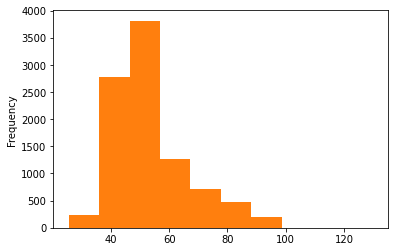

In [306]:
train[train.groupfull == 6].tm1.plot.hist()
train[train.group1 == 3].tm1.plot.hist()

<AxesSubplot:ylabel='Frequency'>

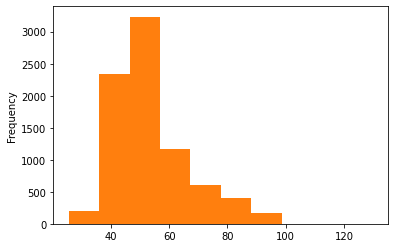

In [307]:
train[train.groupfull == 6].tm1.plot.hist()
train[train.group5 == 3].tm1.plot.hist()

In [308]:
# train = train[train.groupfull == 6]
target = train['tm1']
train = train.drop(['tm1', 'tm'], axis=1)
test = test.drop(['tm1', 'tm'], axis=1)


In [309]:
# test = test.drop(['len_seq', 'unique_chars'], axis=1)

In [310]:
# scaler = MinMaxScaler()

# train = scaler.fit_transform(train)
# test = scaler.transform(test)

In [311]:
test.shape

(2413, 684)

In [312]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size = 0.2, shuffle=True)

**Model evaluation**

In [313]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import catboost


# # Linear Regression

# reg = LinearRegression()
# reg.fit(train, target)
# prediction = reg.predict(test)

# Random Forest

# rfreg = RandomForestRegressor()
# rfreg.fit(train, target)
# prediction = rfreg.predict(test)

# LGBM Regressor

# gbm = lgb.LGBMRegressor(boosting_type='gbdt',
#                         num_leaves=200,
#                         learning_rate=0.01,
#                         max_depth=-1,
#                         n_estimators=10000)

# gbm.fit(train, target,
#         eval_set=[(X_valid, y_valid)],
#         eval_metric='l1',
#         callbacks=[lgb.early_stopping(5)])

# prediction = gbm.predict(test, num_iteration=gbm.best_iteration_)

# Catboost

MAX_ITER = 20000
PATIENCE = 100
DISPLAY_FREQ = 1000

MODEL_PARAMS = {
                'random_seed': 1234,    
                'learning_rate': 0.05,                
                'iterations': MAX_ITER,
                'early_stopping_rounds': PATIENCE,
                'metric_period': DISPLAY_FREQ,
                'use_best_model': True,
#                 'eval_metric': 'Logloss'
                }

mdl = catboost.CatBoostRegressor(**MODEL_PARAMS)

mdl.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
          metric_period = DISPLAY_FREQ
       )

prediction = mdl.predict(test)

0:	learn: 11.8619423	test: 11.9955623	best: 11.9955623 (0)	total: 36.7ms	remaining: 12m 13s
1000:	learn: 6.4577881	test: 8.0158927	best: 8.0158927 (1000)	total: 30.8s	remaining: 9m 44s
2000:	learn: 5.2854101	test: 7.8858205	best: 7.8853440 (1995)	total: 1m	remaining: 9m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 7.840735069
bestIteration = 2848

Shrink model to first 2849 iterations.


In [314]:
# gbm.feature_importances_

In [315]:
# Keras NN

# modelnn = Sequential()
# modelnn.add(Dense(128, activation="leaky_relu"))
# modelnn.add(BatchNormalization())
# modelnn.add(Dropout(0.5))
# modelnn.add(Dense(64, activation="leaky_relu"))
# modelnn.add(BatchNormalization())
# modelnn.add(Dropout(0.5))
# modelnn.add(Dense(32, activation="leaky_relu"))
# modelnn.add(BatchNormalization())
# modelnn.add(Dense(1))

# opt = keras.optimizers.Adam(learning_rate=0.001)

# # loss_fn = tf.keras.losses.MeanSquaredError()
# loss_fn = tf.keras.losses.MeanAbsoluteError()
# modelnn.compile(loss=loss_fn, optimizer=opt)

# early_stopping = keras.callbacks.EarlyStopping(
#     patience=30,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [316]:
#  history = modelnn.fit(train, target, 
#                               batch_size = 512, 
#                               epochs=100, 
#                               shuffle=True,
#                               validation_split=0.2,
#                               callbacks=[early_stopping])

In [317]:
# plt.figure(figsize=(8,8),dpi=200)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','validation'], loc='upper right')
# plt.show()

In [318]:
# prediction = modelnn.predict(test)

In [319]:
m = prediction.sum() / len(prediction)
d = prediction.std()
m, d

(53.9231457612168, 0.681317750310024)

In [320]:
mt = target.sum() / len(target)
dt = target.std()
mt, dt

(51.40803909546652, 12.03198312144454)

In [328]:
# prediction = (prediction - m) * (dt / d) + mt
prediction = (prediction - m) + mt

In [329]:
prediction 

array([50.95025643, 52.32425758, 51.42821878, ..., 50.78739406,
       50.82151973, 51.13980331])

<AxesSubplot:ylabel='Frequency'>

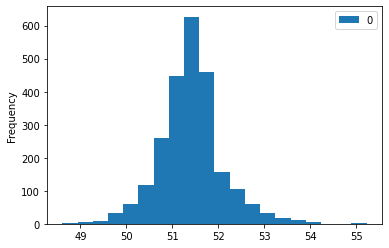

In [330]:
pd.DataFrame(prediction).plot.hist(bins=20)

<AxesSubplot:ylabel='Frequency'>

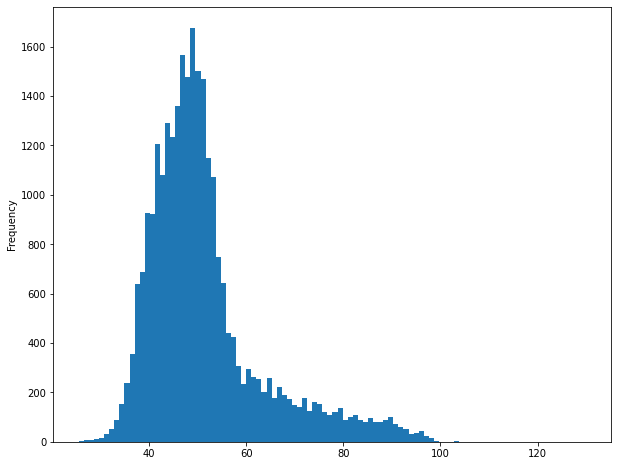

In [324]:
target.plot.hist(bins=100, figsize=(10, 8))

In [325]:
submission['tm'] = prediction

In [326]:
submission.to_csv('submission.csv', index=False)

In [327]:
submission

,seq_id,tm
0,31390,53.465363
1,31391,54.839364
2,31392,53.943325
3,31393,54.591521
4,31394,54.550417
...,...,...
2408,33798,53.644168
2409,33799,53.752395
2410,33800,53.302501
2411,33801,53.336626
